In [1]:
# !pip install seaborn 1> /dev/null # 1> means redirect stdout

# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, classification_report, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
pd.set_option('display.max_rows', 500)
random_state = 42
np.random.seed(random_state)
data_filepath = './data/'
# data_filepath = '/kaggle/input/child-mind-institute-problematic-internet-use/'

# Data

In [2]:
!du -hs $data_filepath*
train_df = pd.read_csv(data_filepath + 'train.csv')
test_df = pd.read_csv(data_filepath + 'test.csv')
train_df.shape, test_df.shape

6.2G	./data/child-mind-institute-problematic-internet-use.zip
 12K	./data/data_dictionary.csv
4.0K	./data/sample_submission.csv
7.9M	./data/series_test.parquet
6.3G	./data/series_train.parquet
8.0K	./data/test.csv
924K	./data/train.csv


((3960, 82), (20, 59))

In [3]:
train_df.sii.value_counts(dropna=False)

sii
0.0    1594
NaN    1224
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [4]:
# sns.relplot(train_df, x='Basic_Demos-Age', y='PCIAT-PCIAT_Total', hue='sii', kind='line', aspect=2.5)

In [5]:
cols_to_drop = ['sii', 'id']
X, y = train_df.drop(columns=cols_to_drop), train_df.sii
X.shape, y.shape

((3960, 80), (3960,))

In [6]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

# Target missing fill by KMeans

In [7]:
numeric_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')),
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
])  
category_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder()),
])
cols_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transormer, num_cols),
    ('category', category_transormer, cat_cols),
])
preproc_df_pipe = Pipeline(steps=[
    ('cols_transformer', cols_transformer),
    ('scaler', StandardScaler()),
    ('nomralize', Normalizer(norm='l2')),
])
# kmeans_pipe = Pipeline(steps=[
#     ('preproc', preproc_df_pipe),
#     ('pca', PCA(n_components=3, random_state=random_state)),
#     ('cluster', MiniBatchKMeans(n_clusters=2, random_state=random_state)),
# ])

# kmeans_pipe
preproc_df_pipe

Pipeline(steps=[('cols_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-999,
                                                                                 strategy='constant'))]),
                                                  ['Basic_Demos-Age',
                                                   'Basic_Demos-Sex',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physica...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Basic_Demos-Enroll_Season',
                                                   'CGAS-Season',
                                                   'Physical-Season',
                                                   'Fitness_Endurance-Season',
                                                   'FGC-Season', 'BIA-Season',
                                                   'PAQ_A-Season',
                                                   'PAQ_C-Season',
                                                   'PCIAT-Season', 'SDS-Season',
                                                   'PreInt_EduHx-Season'])])),
                ('scaler', StandardScaler()), ('nomralize', Normalizer())])

<Axes: xlabel='tsne1', ylabel='tsne2'>

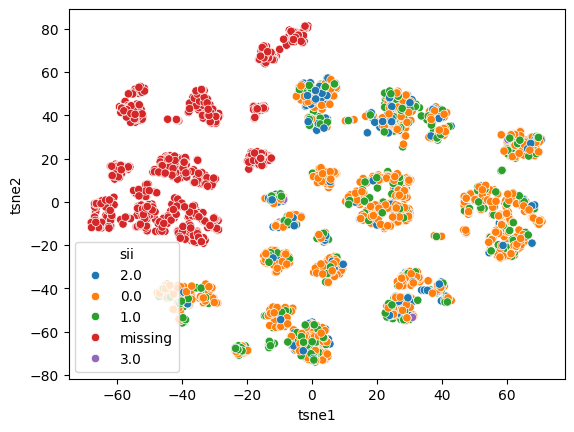

In [8]:
preproc_X = preproc_df_pipe.fit_transform(X)
tsne = TSNE(n_components=2).fit_transform(preproc_X)
tsne = pd.DataFrame(tsne, columns=[f'tsne{i}' for i in range(1, tsne.shape[1]+1)])
tsne['sii'] = y.fillna('missing')
sns.scatterplot(data=tsne, x='tsne1', y='tsne2', hue='sii')

CPU times: user 200 ms, sys: 181 ms, total: 381 ms
Wall time: 45.2 ms


<Axes: xlabel='pca1', ylabel='pca2'>

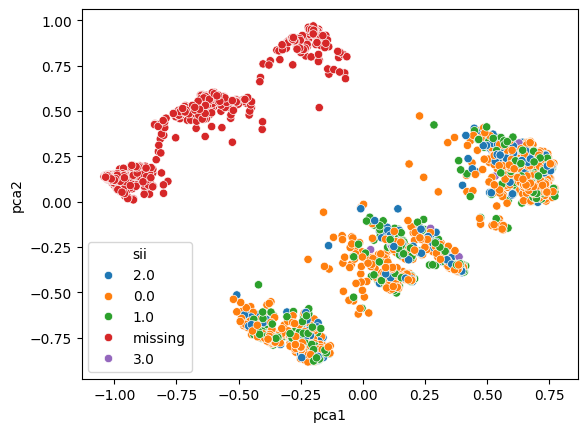

In [9]:
%%time
pca = PCA(n_components=2, random_state=random_state).fit_transform(preproc_X)
pca = pd.DataFrame(pca, columns=[f'pca{i}' for i in range(1, pca.shape[1]+1)])
pca['sii'] = y.fillna('missing')
sns.scatterplot(data=pca, x='pca1', y='pca2', hue='sii')

best_cnt_of_clusters=6


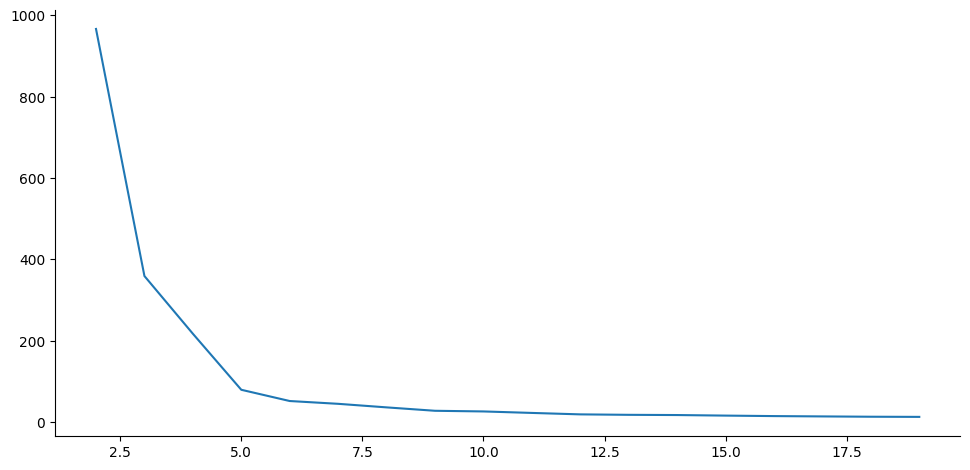

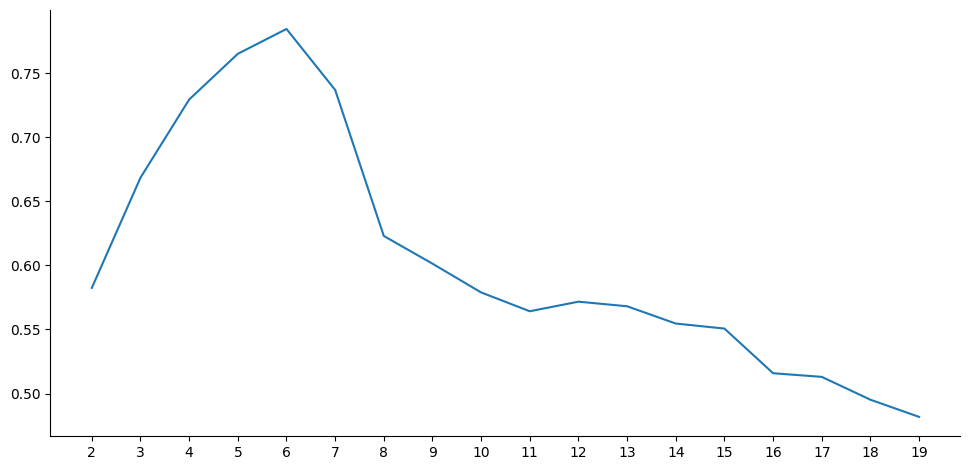

CPU times: user 30 s, sys: 11 s, total: 41 s
Wall time: 4.45 s


In [10]:
%%time
def calc_wcss_silhouette(X, clusters_range=range(3, 10)):
    wcss = list()
    silhouette = list()
    X = PCA(n_components=2, random_state=random_state).fit_transform(X)
    for i in clusters_range:
        cluster = MiniBatchKMeans(n_clusters=i, random_state=random_state)
        labels = cluster.fit_predict(X)
        silhouette.append(silhouette_score(X, labels))
        wcss.append(cluster.inertia_)
    return wcss, silhouette
clusters_range = list(range(2, 20))
preproc_X = preproc_df_pipe.fit_transform(X)
wcss, silhouette = calc_wcss_silhouette(preproc_X, clusters_range)
best_cnt_of_clusters = silhouette.index(max(silhouette)) + clusters_range[0]
print(f'{best_cnt_of_clusters=}')
sns.relplot(x=clusters_range, y=wcss, kind='line', aspect=2)
sns.relplot(x=clusters_range, y=silhouette, kind='line', aspect=2)
import matplotlib.pyplot as plt; plt.xticks(clusters_range) # for x dont round up
plt.show()

In [11]:
cluster = MiniBatchKMeans(n_clusters=best_cnt_of_clusters, random_state=random_state)
preproc_X = preproc_df_pipe.fit_transform(X)
preproc_X = PCA(n_components=2, random_state=random_state).fit_transform(preproc_X)
X_with_clusters = pd.DataFrame(preproc_X, columns=[f'pca{i}' for i in range(1, preproc_X.shape[1]+1)])
X_with_clusters['cluster'] = cluster.fit_predict(preproc_X)
X_with_clusters

,pca1,pca2,cluster
0,0.458963,0.163281,1
1,0.639606,0.100753,1
2,0.237363,-0.294381,3
3,0.712897,0.065608,1
4,-0.971392,0.144966,4
...,...,...,...
3955,0.714050,0.240696,1
3956,-0.676314,0.519847,2
3957,0.689606,0.218821,1
3958,0.385542,-0.348945,3


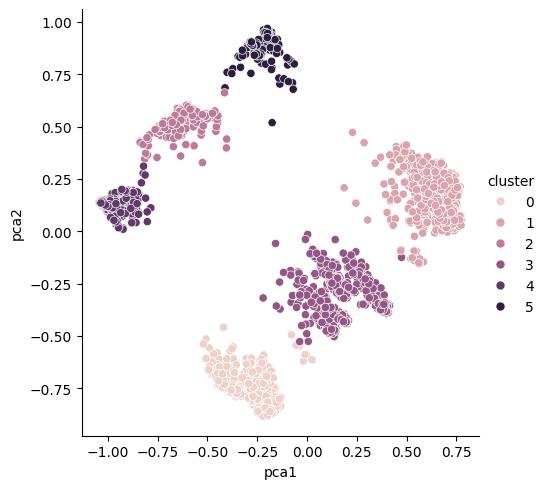

In [12]:
sns.relplot(X_with_clusters, x='pca1', y='pca2', kind='scatter', hue='cluster')

In [20]:
train_pca['sii'] = train_pca['sii'].fillna('missing')
train_pca['hue'] = train_pca['sii'].astype(str) + '_' + train_pca['labels'].astype(str)

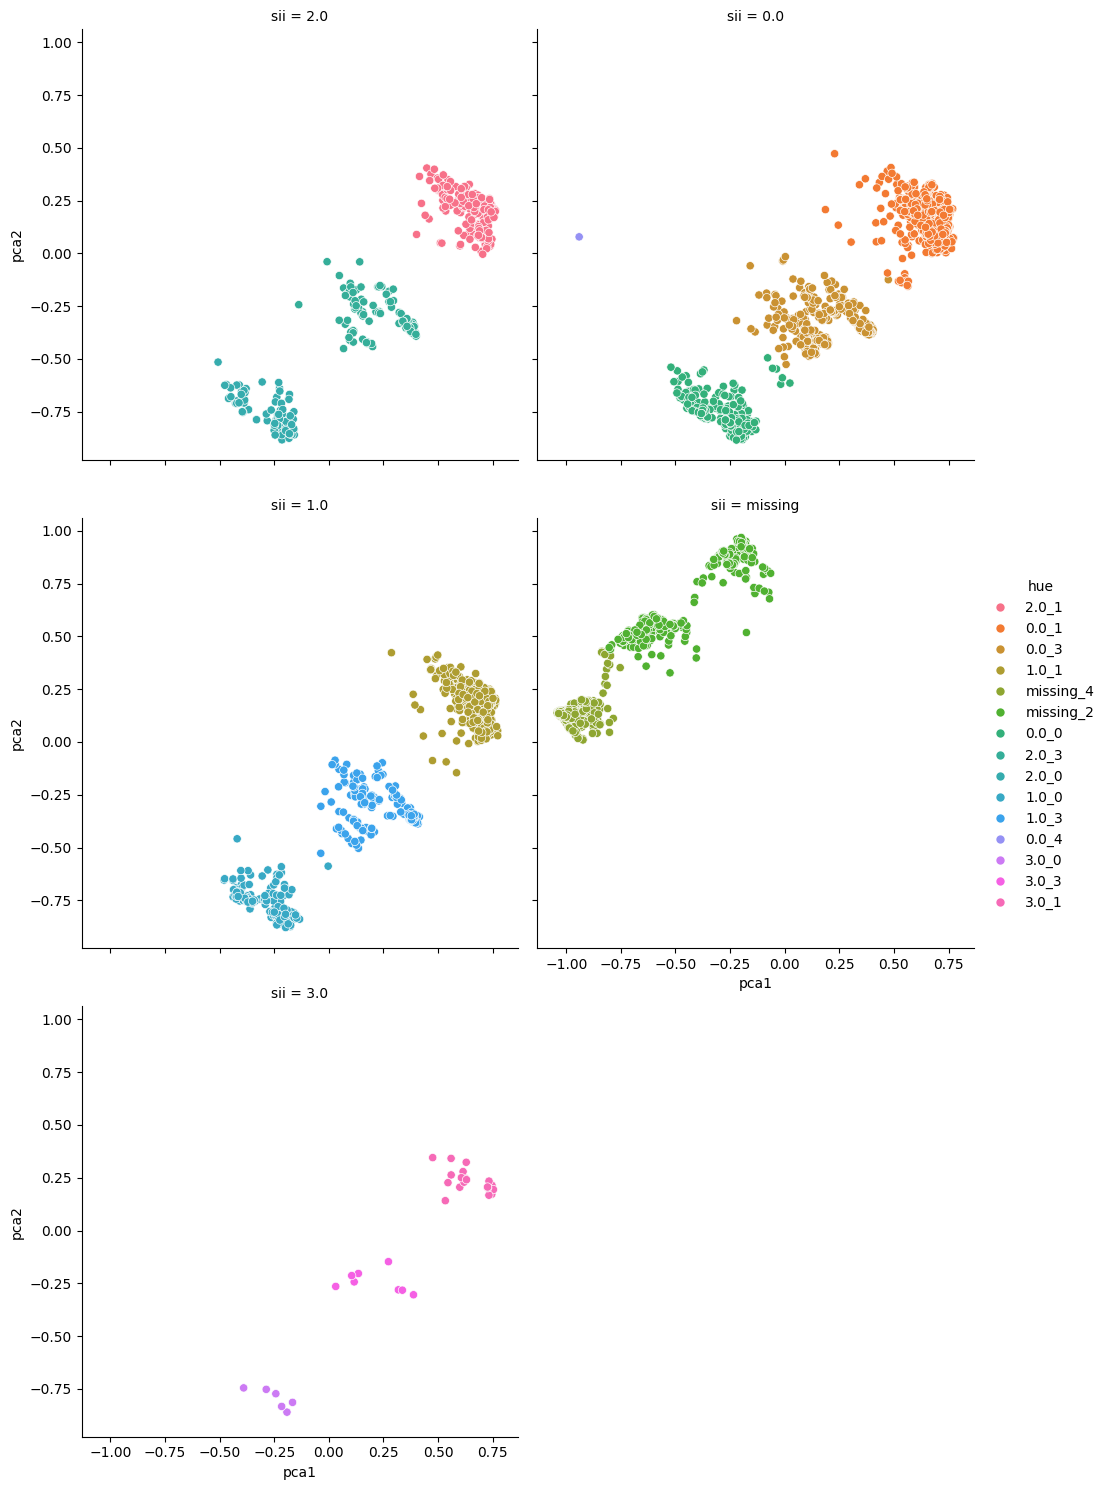

In [21]:
sns.relplot(train_pca, x='pca1', y='pca2', kind='scatter', hue='hue', col='sii', col_wrap=2, aspect=1)

In [22]:
# sns.relplot(train_pca[train_pca.sii == 'missing'], x='pca1', y='pca2', kind='scatter', hue='hue')
# # sns.relplot(train_pca[train_pca.sii == 1.], x='pca1', y='pca2', kind='scatter', hue='hue')
# # sns.relplot(train_pca[train_pca.sii == 2.], x='pca1', y='pca2', kind='scatter', hue='hue')
# # sns.relplot(train_pca[train_pca.sii == 3.], x='pca1', y='pca2', kind='scatter', hue='hue')

In [23]:
train_pca.groupby(['labels','sii']).size().unstack()

sii,0.0,1.0,2.0,3.0,missing
labels,,,,,
0,315.0,160.0,81.0,6.0,NaN
1,931.0,397.0,202.0,20.0,NaN
2,NaN,NaN,NaN,NaN,433.0
3,347.0,173.0,95.0,8.0,NaN
4,1.0,NaN,NaN,NaN,791.0


# Clf with kmeans sii missing fill

In [ ]:
cols_to_drop = ['sii', 'id', 'cluster']
train_df = pd.read_csv(data_filepath + 'train.csv')
train_df['cluster'] = train_pca.labels
train_df.loc[train_df.cluster==0, 'sii'] = train_df.loc[train_df.cluster==0, 'sii'].fillna(0.0)
train_df.loc[train_df.cluster==1, 'sii'] = train_df.loc[train_df.cluster==1, 'sii'].fillna(1.0)
train_df.loc[train_df.cluster==2, 'sii'] = train_df.loc[train_df.cluster==2, 'sii'].fillna(0.0)
target_source_cols = [c for c in train_df.columns if c.startswith('PCIAT')]
train_df.drop(columns=target_source_cols, inplace=True)
X, y = train_df.drop(columns=cols_to_drop, errors='ignore'), train_df.sii
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()
X.shape, y.shape

In [ ]:
y.value_counts(dropna=False)

In [ ]:
numeric_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')),
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
])  
category_transormer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder()),
])
cols_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transormer, num_cols),
    ('category', category_transormer, cat_cols),
])
preproc_df_pipe = Pipeline(steps=[
    ('cols_transformer', cols_transformer),
    ('scaler', StandardScaler()),
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=random_state)
X_train = preproc_df_pipe.fit_transform(X_train)
X_test = preproc_df_pipe.transform(X_test)

In [ ]:
%%time
clf = CatBoostClassifier()
clf.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    logging_level='Silent', 
)
preds = clf.predict(X_test)
print(cohen_kappa_score(y_test, preds))
print(classification_report(y_test, preds))

# Cross validation

In [ ]:
%%time
_clf = CatBoostClassifier(verbose=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=.3, random_state=random_state)
_pipeline = Pipeline([('transformer', preproc_df_pipe), ('estimator', _clf)])
scoring = {
    'f1': 'f1_macro',
    'cohen_kappa_score': make_scorer(cohen_kappa_score), 
}
scores = cross_validate(_pipeline, X, y, cv=cv, scoring=scoring)
for metric, folds_score in scores.items():
    if not metric.startswith('test_'): continue
    print(metric, folds_score.mean().round(4), folds_score.std().round(4))

# Save

In [ ]:
test_df = pd.read_csv(data_filepath + 'test.csv')
test_df['sii'] = clf.predict(preproc_df_pipe.transform(test_df[X.columns]))
test_df.sii.value_counts()

In [ ]:
test_df[['id', 'sii']].to_csv('submission.csv', index=False)
!du -hs 'submission.csv'

In [ ]:
# Score: 0.320